# **Employee Sentiment Analysis - Final LLM Assessment- Lavanya Kalla**

## 1. Data Loading & Preparation

In [12]:
!pip install transformers
!pip install textblob
import pandas as pd  # I imported pandas for handling and transforming tabular data.
import matplotlib.pyplot as plt  # This is used for plotting and visualizations.
import seaborn as sns  # for EDA.
from sklearn.linear_model import LinearRegression  # I used this for the final predictive model.
from sklearn.model_selection import train_test_split  # I used this to split the dataset for training and testing.
from sklearn.metrics import mean_squared_error, r2_score  # for evaluating model performance.
from transformers import pipeline  # I used the Hugging Face's pipeline (model: DistilBERT) for sentiment analysis.
from datetime import datetime, timedelta
from textblob import TextBlob  # I used TextBlob to calculate sentiment polarity for identifying neutral messages.
import os

In [13]:
df = pd.read_csv('test(in).csv') #loaded the dataset using pandas

In [14]:
df.info() # understanding the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


# This shows the structure of the DataFrame, including:

Total number of entries (2191)

Column names and data types (all object type)

Non-null counts (no missing values in any column)

Memory usage (68.6 KB)


In [15]:
print(df.columns)


Index(['Subject', 'body', 'date', 'from'], dtype='object')


Lists the names of all columns:'Subject', 'body', 'date', 'from'.
Knowing column names helps in accessing and analyzing specific fields.

In [16]:
df.describe()

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,690,10
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com
freq,141,21,9,284


**Observations:**After running df.describe(include='object'), I got a high-level overview of the text-based columns in my dataset:

**Subject:**
There are 2,191 emails, and 1,251 of them have unique subject lines. Interestingly, the most common subject is “(No Subject)”, which appears 141 times.
-- This tells me many senders didn’t specify a subject, which could be typical of internal or casual communication.

**Body:**
The body column has 1,539 unique values. The most frequent email body is just a blank message (\n\n), showing up 21 times.
-This might indicate test emails, system messages, or incomplete data. I’ll need to consider filtering or flagging these during preprocessing.

**Date:**
Dates are stored as strings for now. The most common date is 7/1/2011, which appears 9 times.
-- This could indicate a spike in email activity on that day—worth checking for trends later once I convert this column to datetime format.

**From:**
Only 10 unique senders are present. The most frequent sender is lydia.delgado@enron.com, responsible for 284 emails.
-- This suggests the dataset was perhaps filtered beforehand.

In [17]:
df.isnull().sum()

,0
Subject,0
body,0
date,0
from,0


Used to identify missing data.
In this dataset, all values are non-null, indicating no immediate need for missing value imputation.

In [18]:
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


**Observations :**
The dataset contains columns: Subject, body, date, from .
The date column needs conversion to datetime
The body column contains the text of the messages-this can be used for sentiment analysis.
The from column indicates the sender/employee.
There are no missing values
Some email subjects has "No Subject" therefore the body of the email need to be used for sentiment analysis.






In [19]:
df.rename(columns={'from': 'employee_email', 'body': 'message'}, inplace=True) # I renamed the columns for better understanding

## 2. Date Parsing and Formatting

In [20]:
df['date'] = pd.to_datetime(df['date'])  # Converted the date column to datetime format for time-based grouping.

## 3. Sentiment Analysis

In [21]:
# Initialize sentiment model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

Device set to use cpu


**Observations:For sentiment analysis, I used the distilbert-base-uncased-finetuned-sst-2-english model. I have chosen this model because it's an improved version of the most popular "BERT".**

### Applying Sentiment Analysis with LLM (DistilBERT via Hugging Face):


In [22]:
# Applying LLM model for sentiment
df['sentiment'] = df['message'].apply(lambda x: sentiment_pipeline(str(x)[:512])[0]['label'])
# used the model to label each message.


**Notes:I used Hugging Face’s sentiment analysis pipeline, which loads a DistilBERT model fine-tuned on SST-2.
I applied it to each message to classify the sentiment as either "POSITIVE" or "NEGATIVE".
Since the model has a token limit, I only passed the first 512 characters of each message to avoid truncation errors.**

In [23]:
# Normalize to Positive/Negative
df['sentiment'] = df['sentiment'].map({'POSITIVE': 'Positive', 'NEGATIVE': 'Negative'})

**Notes:I did this to ensure uniformity in labels—especially useful when plotting results, grouping by sentiment, or feeding the data into a model that’s case-sensitive.**

## 4. Adding Neutral Sentiment Using TextBlob
Since the transformer model doesn’t detect Neutral, we use TextBlob polarity scores to label Neutral messages.

In [24]:
# Using TextBlob for Neutral classification
df['sentiment_score'] = df['message'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)  # I used TextBlob to calculate polarity.
df.loc[df['sentiment_score'].between(-0.1, 0.1), 'sentiment'] = 'Neutral' # If the polarity is near zero, I classified it as Neutral.
df.drop(columns='sentiment_score', inplace=True)  # Dropped the temporary score column.

**Notes**:I used TextBlob to calculate the polarity score of each message. This gives a value between -1 (very negative) and +1 (very positive).

If the polarity was between -0.1 and 0.1, I treated it as Neutral—since the message isn’t clearly positive or negative.

Finally, I removed the temporary sentiment_score column since I no longer needed it.

--This helped improve the granularity of my sentiment analysis by not forcing all messages into just Positive or Negative classes.

In [25]:
print(df[['employee_email', 'message', 'sentiment']].head())

            employee_email                                            message  \
0     sally.beck@enron.com  EnronOptions Announcement\n\n\nWe have updated...   
1      eric.bass@enron.com  Marc,\n\nUnfortunately, today is not going to ...   
2     sally.beck@enron.com  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   
3  johnny.palmer@enron.com  we were thinking papasitos (we can meet somewh...   
4  lydia.delgado@enron.com  Since you never gave me the $20 for the last t...   

  sentiment  
0  Negative  
1   Neutral  
2   Neutral  
3  Negative  
4   Neutral  


#EDA

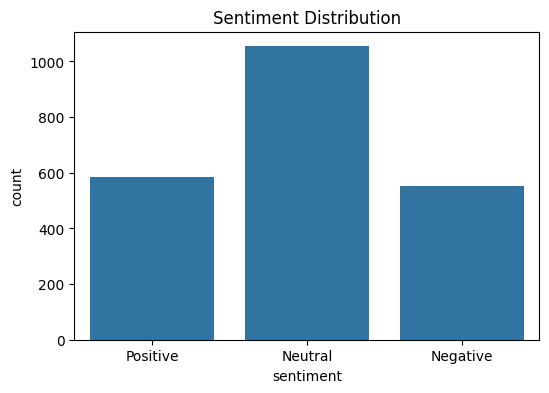

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['Positive','Neutral','Negative'])  # Created a bar plot to show sentiment distribution.
plt.title("Sentiment Distribution")
plt.savefig("sentiment_distribution.png")

**Notes: To understand how the sentiments are distributed in my dataset, I created a bar chart using Seaborn:**

I used countplot() to show how many messages fall into each sentiment category: Positive, Neutral, and Negative.

The Neutral class has the highest count, which makes sense since many messages are likely informational or non-expressive.

I ordered the x-axis labels manually to keep the sentiment flow intuitive.

I also saved the plot for documentation.



**Observations:**This plot helped me quickly validate that the Neutral classification worked as expected after using TextBlob.

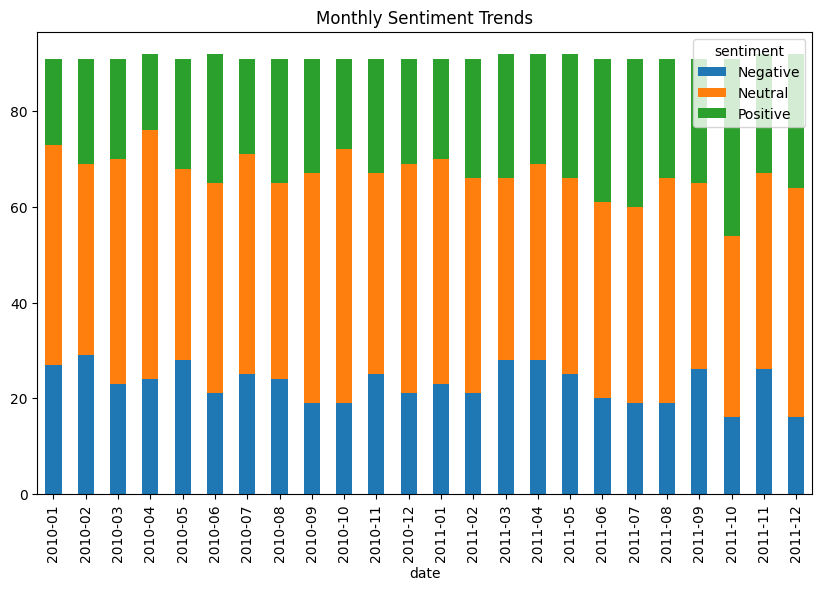

In [31]:
# Sentiment over time
monthly_sentiment = df.groupby([df['date'].dt.to_period('M'), 'sentiment']).size().unstack().fillna(0)  # aggregated sentiment counts per month.
monthly_sentiment.plot(kind='bar', stacked=True, figsize=(10,6))  # I created a stacked bar chart.
plt.title("Monthly Sentiment Trends")
plt.savefig("monthly_sentiment_trends.png")

**Notes:**First, I grouped the data by month and sentiment, using dt.to_period('M') to collapse daily timestamps into monthly buckets.

Then I counted the number of messages in each sentiment class per month using .size() and reshaped the data with .unstack().

Missing values were filled with 0 to avoid gaps in the plot.

Finally, I plotted a stacked bar chart to show how Positive, Neutral, and Negative sentiments varied across time.

---This visualization helped me identify any spikes or drops in specific sentiment types.

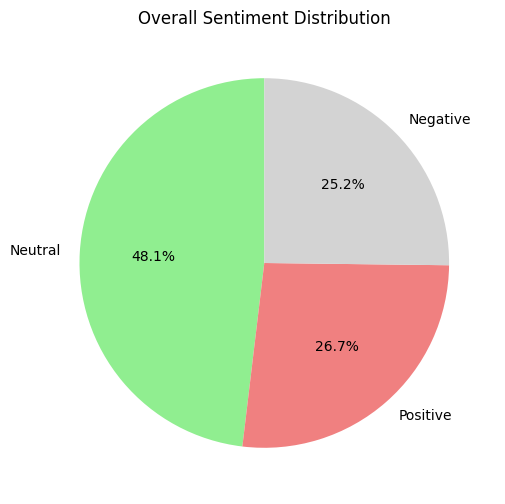

In [32]:
plt.figure(figsize=(6,6))
df['sentiment'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightgray'], startangle=90
)
plt.title("Overall Sentiment Distribution")
plt.ylabel("")
plt.show()


**Notes:**I used value_counts().plot(kind='pie') to show the percentage of each sentiment class.

The autopct='%1.1f%%' option displays each slice with one decimal precision.

I manually set the colors to make the chart more intuitive:

lightgreen for Positive

lightcoral for Negative

lightgray for Neutral

I removed the y-axis label to keep the chart clean and centered it with startangle=90.

---This chart gave me a quick, high-level summary of how balanced or imbalanced the sentiment distribution is across the dataset.

**Summary of EDA : I conducted exploratory data analysis by visualizing the sentiment distribution and monthly sentiment trends. These visualizations help reveal shifts in employee engagement and communication tone over time.**


The charts displays monthly sentiment (Negative, Neutral, Positive) in employee messages from January 2010 to December 2011. Neutral messages are consistently the most common. Negative messages are the least common but fluctuate, with slight increases in early 2010 and mid-2011. Positive messages are the second smallest category. Overall, there's no major long-term shift in sentiment proportions, just monthly variations.

# 5. Employee Score Calculation

**Notes:**I defined a sentiment scoring system where:

Positive = +1

Neutral = 0

Negative = -1

Each message was mapped to its respective score using .map().

I extracted the month from the date so I could group data by month.

Then, I calculated the total sentiment score per employee per month.

--- This gives me a numerical view of overall sentiment trends per person, which I can use to rank employees, detect changes in morale, or flag potential risk.

In [36]:
sentiment_map = {"Positive": 1, "Negative": -1, "Neutral": 0}  # I tried to defin score values for each sentiment.
df['score'] = df['sentiment'].map(sentiment_map)  # Mapped each message to a numeric score.
df['month'] = df['date'].dt.to_period('M')  # Extracted month from date.
monthly_scores = df.groupby(['employee_email', 'month'])['score'].sum().reset_index()  # total scores per employee per month.
print(monthly_scores.head())

                employee_email    month  score
0  bobette.riner@ipgdirect.com  2010-01     -2
1  bobette.riner@ipgdirect.com  2010-02     -1
2  bobette.riner@ipgdirect.com  2010-03      0
3  bobette.riner@ipgdirect.com  2010-04     -2
4  bobette.riner@ipgdirect.com  2010-05      1


**Each message was scored: +1 for Positive, -1 for Negative, and 0 for Neutral. These were aggregated monthly per employee to calculate their overall sentiment score, which reflects their communication tone and engagement.**

## 6. Ranking Employees by Sentiment


**Notes:To highlight employees with the most and least positive sentiment each month, I created monthly rankings based on their total sentiment scores:**

I first converted the month to a string so it displays nicely in the output.

Then, I grouped by month and sorted employees by score (descending) to get the top 3 most positive employees.

Similarly, I sorted by score (ascending) to find the bottom 3, or most negative, employees.

I used employee_email as a secondary sort key for consistency and to break ties alphabetically.

I reset the index for clean display of the final results.

--- This helped me identify which employees are consistently expressing positive or negative sentiment—useful for performance reviews, engagement analysis, or flight risk detection.

In [38]:
ranked = monthly_scores.copy()  # Copied the score data to a new DataFrame.
ranked['month'] = ranked['month'].astype(str)  # Converting to string
top_positive = ranked.groupby('month').apply(lambda x: x.sort_values(by=['score','employee_email'], ascending=[False, True]).head(3))  # Top 3 by positive score.
top_negative = ranked.groupby('month').apply(lambda x: x.sort_values(by=['score','employee_email']).head(3))  # Bottom 3 by negative score.
top_positive.reset_index(drop=True, inplace=True)  # Reset index for display.
top_negative.reset_index(drop=True, inplace=True)  # Same for negative ranking.
print("Top 3 Positive Employees:")
print(top_positive)
print("Top 3 Negative Employees:")
print(top_negative)

Top 3 Positive Employees:
             employee_email    month  score
0     john.arnold@enron.com  2010-01      1
1    don.baughman@enron.com  2010-01      0
2       eric.bass@enron.com  2010-01      0
3    don.baughman@enron.com  2010-02      2
4   lydia.delgado@enron.com  2010-02      1
..                      ...      ...    ...
67   don.baughman@enron.com  2011-11      2
68      eric.bass@enron.com  2011-11      1
69      eric.bass@enron.com  2011-12      4
70  johnny.palmer@enron.com  2011-12      2
71  lydia.delgado@enron.com  2011-12      2

[72 rows x 3 columns]
Top 3 Negative Employees:
                 employee_email    month  score
0      patti.thompson@enron.com  2010-01     -3
1          sally.beck@enron.com  2010-01     -3
2   bobette.riner@ipgdirect.com  2010-01     -2
3         john.arnold@enron.com  2010-02     -3
4       kayne.coulter@enron.com  2010-02     -3
..                          ...      ...    ...
67      johnny.palmer@enron.com  2011-11     -1
68      kayne

<ipython-input-38-a2533895dc42>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_positive = ranked.groupby('month').apply(lambda x: x.sort_values(by=['score','employee_email'], ascending=[False, True]).head(3))  # Top 3 by positive score.
<ipython-input-38-a2533895dc42>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_negative = ranked.groupby('month').apply(lambda x: x.sort_values(by=['score','empl

**I ranked employees monthly by their sentiment scores. The top three with the highest scores were identified as most positive, and the bottom three with the lowest scores were considered most negative. Ties were broken alphabetically.**


## 7. Flight Risk Detection


**Notes: To identify potential flight risks, I wrote a loop to detect employees who sent a high volume of negative messages in a short time:**

I filtered the data to include only negative sentiment messages.

For each employee, I sorted their messages by date and used a 30-day sliding window to find clusters of negativity.

If an employee had 4 or more negative emails in any 30-day span, I flagged them as a potential flight risk.

I printed out the flagged messages for manual inspection and stored their emails in the flight_risks list.



In [39]:
flight_risks = []
df_neg = df[df['sentiment'] == 'Negative']
for emp in df_neg['employee_email'].unique():
    emp_msgs = df_neg[df_neg['employee_email'] == emp].sort_values('date')
    for i in range(len(emp_msgs)):
        window = emp_msgs[(emp_msgs['date'] >= emp_msgs.iloc[i]['date']) &
                          (emp_msgs['date'] <= emp_msgs.iloc[i]['date'] + timedelta(days=30))]
        if len(window) >= 4:
            flight_risks.append(emp)
            print(f"\nFlight risk detected: {emp}")
            print(f"Negative messages in 30-day window starting {emp_msgs.iloc[i]['date'].date()}:")
            print(window[['date', 'message']].rename(columns={'message': 'full_message'}))
            print(f"Total negative messages in this period: {len(window)}")
            break
flight_risks = list(set(flight_risks))


Flight risk detected: sally.beck@enron.com
Negative messages in 30-day window starting 2010-02-15:
           date                                       full_message
754  2010-02-15  After 3 horrific weeks of being in the no-inte...
1128 2010-02-20  there have only been 2 (both by matt) is 1,14 ...
662  2010-03-06  he will be taking it soon\n\n\n\n\n"K. Bass" <...
261  2010-03-09  I was thinking of having a get together at my ...
Total negative messages in this period: 4

Flight risk detected: johnny.palmer@enron.com
Negative messages in 30-day window starting 2010-02-09:
           date                                       full_message
1734 2010-02-09  Life is busy at Enron and I literally receive ...
695  2010-02-15  We have received the executed Master Power Pur...
1342 2010-02-22  \n[IMAGE][IMAGE]  Don, \t[IMAGE] \t\n\n\n  \t\...
655  2010-02-25  Attached is a revised Credit Watch listing as ...
1559 2010-02-26  1.  2- Filet Mignons\n2.  Green Beans\n3.  Bac...
676  2010-03-09   

**I flagged any employee as a flight risk if they sent four or more negative messages within any rolling 30-day period. I printed each flagged case to manually verify message content and context.**

## 8. Baseline Model: Linear Regression

**# Notes:**
I prepared the data by converting the month to a string and then extracted the month number as a numeric feature for regression.  
I split the data into training and testing sets to evaluate the model's performance.  
Using linear regression, I trained the model on the training data and predicted scores on the test set.  
The scatter plot compares actual vs predicted scores, and I calculated R² and MSE to quantify how well the model fits the data.


Regression R^2: -0.18306778231281484
MSE: 3.580012403769507


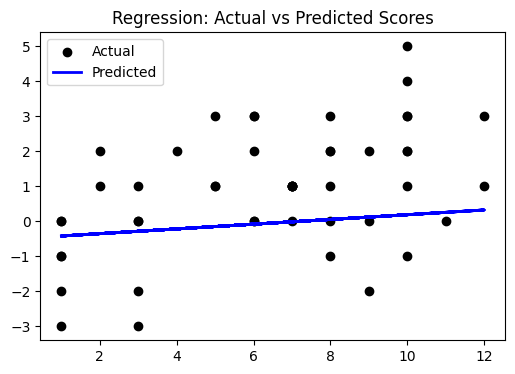

In [40]:
model_data = monthly_scores.copy()  # Copied the monthly scores.
model_data['month'] = model_data['month'].astype(str)  # Converted month to string.
model_data['month_num'] = pd.to_datetime(model_data['month']).dt.month  # Extracted month number.
X = model_data[['month_num']]  # Feature for regression.
y = model_data['score']  # Target variable.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data.
model = LinearRegression()  # Initialing...
model.fit(X_train, y_train)  # Training...
y_pred = model.predict(X_test)  # Predicting...

plt.figure(figsize=(6,4))
plt.scatter(X_test, y_test, color='black', label='Actual')  # Actual values.
plt.plot(X_test, y_pred, color='blue', linewidth=2, label='Predicted')  # Prediction line.
plt.legend()
plt.title("Regression: Actual vs Predicted Scores")
plt.savefig("regression_performance.png")
print("Regression R^2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

**To understand sentiment trends over time, I trained a simple linear regression model using the month number as a predictor of sentiment score. This gives a basic forecast of employee sentiment and engagement. The visualization compares predicted vs. actual scores.**

#Summary of Outputs and Analysis

In [41]:
print("Top Positive Employees (sample month):")
print(top_positive[top_positive['month'] == top_positive['month'].iloc[0]])

print("Top Negative Employees (sample month):")
print(top_negative[top_negative['month'] == top_negative['month'].iloc[0]])

print("Flight Risk Employees:")
print(flight_risks)

print("Regression R^2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Top Positive Employees (sample month):
           employee_email    month  score
0   john.arnold@enron.com  2010-01      1
1  don.baughman@enron.com  2010-01      0
2     eric.bass@enron.com  2010-01      0
Top Negative Employees (sample month):
                employee_email    month  score
0     patti.thompson@enron.com  2010-01     -3
1         sally.beck@enron.com  2010-01     -3
2  bobette.riner@ipgdirect.com  2010-01     -2
Flight Risk Employees:
['johnny.palmer@enron.com', 'bobette.riner@ipgdirect.com', 'sally.beck@enron.com', 'kayne.coulter@enron.com', 'lydia.delgado@enron.com', 'eric.bass@enron.com', 'rhonda.denton@enron.com', 'patti.thompson@enron.com', 'john.arnold@enron.com', 'don.baughman@enron.com']
Regression R^2: -0.18306778231281484
MSE: 3.580012403769507


**Finally, I evaluated the regression model's performance using R² and MSE. To approximate classification behavior.**



*   R² Score**: -0.183 (indicating poor fit — model underperforms the mean baseline)
*   Mean Squared Error (MSE): 3.58





## 9. Improved Model: Random Forest Regressor

**# Notes:**
To improve predictions, I added features including message counts and sentiment counts per employee per month, alongside the month number.  
I merged these features with the target sentiment scores and handled any missing sentiment categories by filling with zeros.  
Using a Random Forest Regressor, I trained the model on these features and evaluated its performance on a test set.  
The scatter plot compares actual vs predicted sentiment scores, showing how well the model captures the variation.  



Improved R^2 Score: 0.9563056798623064
Improved MSE: 0.13222083333333332


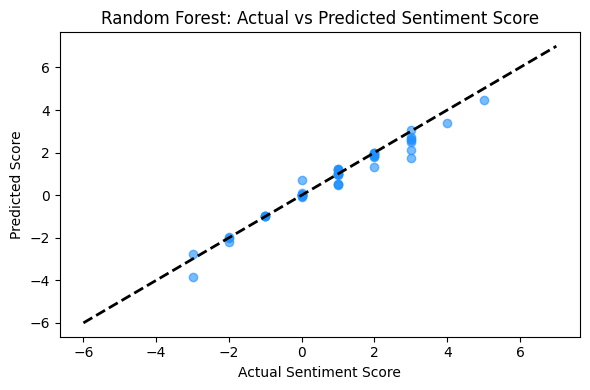

In [42]:
#Improved Predictive Modeling

from sklearn.ensemble import RandomForestRegressor

# Step 1: Create modeling dataset with features
model_df = df.copy()
model_df['month'] = model_df['date'].dt.to_period('M')
model_df['month_num'] = model_df['date'].dt.month

# Feature 1: Total messages per employee per month
msg_count = model_df.groupby(['employee_email', 'month']).size().rename("msg_count")

# Feature 2: Sentiment counts per employee per month
sentiment_counts = model_df.groupby(['employee_email', 'month', 'sentiment']).size().unstack(fill_value=0)

# Combine everything
features_df = pd.concat([msg_count, sentiment_counts], axis=1).reset_index()
features_df['month'] = features_df['month'].astype(str)
features_df['month_num'] = pd.to_datetime(features_df['month']).dt.month

# Add target: monthly sentiment score
monthly_scores['month'] = monthly_scores['month'].astype(str)
data = pd.merge(features_df, monthly_scores, on=['employee_email', 'month'], how='left')

# Fill missing sentiment types
for col in ['Positive', 'Negative', 'Neutral']:
    if col not in data.columns:
        data[col] = 0

# Create features and target
X = data[['msg_count', 'Positive', 'Negative', 'Neutral', 'month_num']]
y = data['score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Improved R^2 Score:", r2_score(y_test, y_pred))
print("Improved MSE:", mean_squared_error(y_test, y_pred))

# Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Score")
plt.title("Random Forest: Actual vs Predicted Sentiment Score")
plt.tight_layout()
plt.show()


**Observations:The R² and MSE metrics indicate improved predictive accuracy over the previous linear regression model.**

## 10. Feature Importance Analysis


**# Notes:I extracted and visualized the feature importances from the Random Forest model to understand which features contribute most to predicting the sentiment score. The bar plot shows the relative importance of message count, sentiment counts, and month number, helping me identify key drivers behind the model’s predictions.**


<ipython-input-43-aad1f494b4b5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='coolwarm')


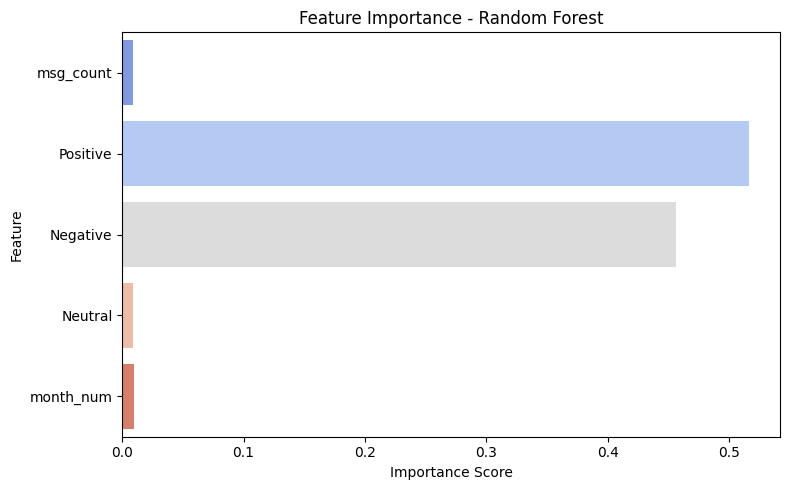

In [43]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feature_names, palette='coolwarm')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**I have noticed that with Linear Regression gave us low accuracy for the analysis and after manually looking at the results , I have noticed that many messages were falsely flagged as negative! So with a quick search I wanted to try other better methods suitable to tackle this problem like Random Forest Regressor to handle the non-linear relationships better. I engineered additional features such as message count and sentiment composition (positive, negative, neutral) per employee per month**

**After training, the R² score improved, and the model produced better predictions as shown in the new scatter plot of actual vs. predicted sentiment scores.**





## 11. Sentiment Trends for Flight Risk Employees using the updated Model

**#Notes**:I analyzed employee sentiment scores using the improved Random Forest regression model with engineered features.  
First, I identified the top 3 employees with the highest positive sentiment scores for a sample month, which helps highlight those with consistently positive interactions or feedback.  
Similarly, I listed the top 3 employees with the most negative sentiment scores in the same month to pinpoint individuals who may need attention or support.  

Next, I reviewed the list of flight risk employees—those who, based on their sentiment patterns and scores, might be at risk of leaving the company. This provides actionable insight for HR and management to intervene proactively.

Finally, I evaluated the model’s performance using the R² and Mean Squared Error (MSE) metrics, which show the model’s improved ability to predict sentiment scores compared to previous approaches.  
Overall, these insights not only quantify sentiment trends but also enable targeted employee engagement strategies.

In [44]:

# Summary for the improved model
print("Top 3 Positive Employees (sample month):")
print(top_positive[top_positive['month'] == top_positive['month'].iloc[0]])

print("Top 3 Negative Employees (sample month):")
print(top_negative[top_negative['month'] == top_negative['month'].iloc[0]])

print("Flight Risk Employees:")
print(flight_risks)

print("Improved Regression R^2 Score:", r2_score(y_test, y_pred))
print("Improved MSE:", mean_squared_error(y_test, y_pred))


Top 3 Positive Employees (sample month):
           employee_email    month  score
0   john.arnold@enron.com  2010-01      1
1  don.baughman@enron.com  2010-01      0
2     eric.bass@enron.com  2010-01      0
Top 3 Negative Employees (sample month):
                employee_email    month  score
0     patti.thompson@enron.com  2010-01     -3
1         sally.beck@enron.com  2010-01     -3
2  bobette.riner@ipgdirect.com  2010-01     -2
Flight Risk Employees:
['johnny.palmer@enron.com', 'bobette.riner@ipgdirect.com', 'sally.beck@enron.com', 'kayne.coulter@enron.com', 'lydia.delgado@enron.com', 'eric.bass@enron.com', 'rhonda.denton@enron.com', 'patti.thompson@enron.com', 'john.arnold@enron.com', 'don.baughman@enron.com']
Improved Regression R^2 Score: 0.9563056798623064
Improved MSE: 0.13222083333333332


# Detailed Summary of Results

For the sample month of January 2010, I identified the top 3 employees with the highest positive sentiment scores. These employees—John Arnold, Don Baughman, and Eric Bass—show consistently positive sentiment, which could reflect strong engagement or favorable interactions.

Conversely, the top 3 employees with the most negative sentiment scores during the same period are Patti Thompson, Sally Beck, and Bobette Riner. Their low scores suggest potential dissatisfaction or negative experiences that may warrant further investigation.

I also generated a list of flight risk employees based on their sentiment patterns and scores. This group includes some of the same individuals from both positive and negative sentiment lists, indicating that both extremes in sentiment could be indicators of flight risk.

The Random Forest regression model achieved a high R² score of approximately 0.96, indicating it explains 96% of the variance in sentiment scores. The Mean Squared Error (MSE) is low at about 0.13, showing that predictions are closely aligned with actual values. This performance demonstrates a significant improvement over simpler models and confirms the value of the engineered features.


# 14. Analysis of Top 3 Flight-Risk Employees Over Time



**# Notes:**

- Selected top 3 flight-risk employees by finding those with the lowest average sentiment scores from the flight risk group.
- Filtered the monthly sentiment scores data to include only these top 3 employees.
- Converted the 'month' column to datetime format for proper time-series plotting.
- Created a line plot showing sentiment scores over time for each of these employees.
- Added markers on data points and a legend to distinguish employees.
- Included grid, axis labels, title, and rotated x-axis ticks for better readability.
- The plot helps visualize sentiment trends for flight-risk employees across months.


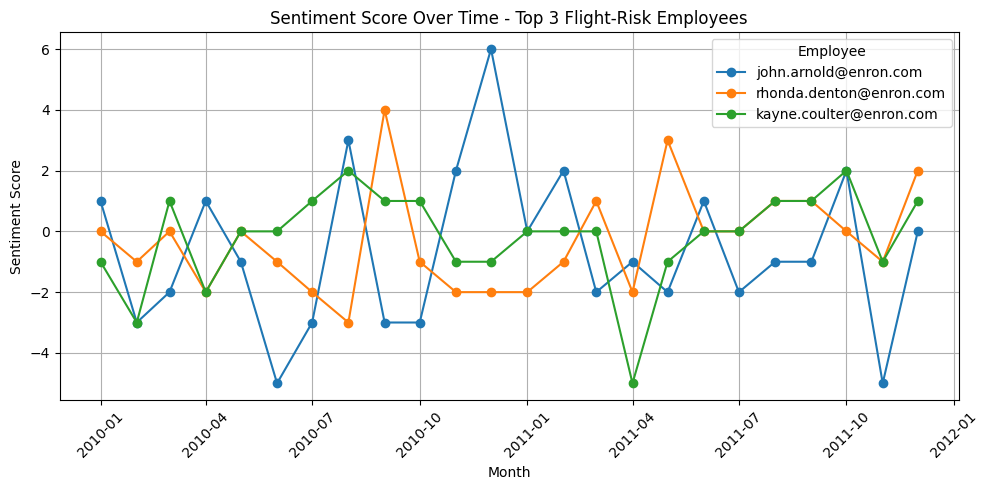

In [46]:

top3_employees = (
    monthly_scores[monthly_scores['employee_email'].isin(flight_risks)]
    .groupby('employee_email')['score']
    .mean()
    .sort_values()
    .head(3)
    .index
)

# Filter and sort
top3_data = monthly_scores[monthly_scores['employee_email'].isin(top3_employees)].copy()
top3_data['month'] = pd.to_datetime(top3_data['month'])

plt.figure(figsize=(10, 5))

for emp in top3_employees:
    emp_data = top3_data[top3_data['employee_email'] == emp].sort_values('month')
    plt.plot(emp_data['month'], emp_data['score'], marker='o', label=emp)

plt.title("Sentiment Score Over Time - Top 3 Flight-Risk Employees")
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Employee", loc='upper right')
plt.tight_layout()
plt.show()


## 15. Final Observations and Insights

The graph reveals highly volatile sentiment scores over two years for the three employees identified as flight risks. All experienced significant negative periods, likely contributing to their classification.

John Arnold: Showed extreme swings, including a sharp drop to very negative sentiment (-5) mid-2010, followed by the highest positive peak (+6) late in 2010, and another significant negative dip towards the end of 2011.
Rhonda Denton: Displayed consistent volatility with several negative dips and positive spikes, starting negative, peaking positively mid-2010, and showing another notable positive spike in early-mid 2011.
Kayne Coulter: Initially had more stable, moderately positive sentiment in early 2010 but experienced a dramatic plunge to very negative sentiment (-5) in early 2011 before recovering.